In [13]:
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

def plot_nested_sensitivity_bars(
    stats_data,
    stats_order=None,
    title="Sensitivity metrics (nested bar chart)",
    y_label="Value",
    figsize=(14, 7),
    abbreviations=None,
    value_format=None,          # callable: (v) or (v, stat) -> str
    annotate_decimals=1,        # used only if neither per-metric nor format_map nor value_format is provided
    format_map=None,            # optional: dict {metric_key: format_string}
    bar_alpha=0.85,
    annotate_rotation=45,
    scenario_label_rotation=45,
    scenario_spacing=0.06,
    bar_width=0.12,
    bottom_margin_for_labels=0.12,
    stat_label_map=None         # optional: {metric_key: display_label}
    # (legend placement adjusted: now inside axes)
    # NOTE: if legend overlaps data, reduce fig size or adjust top_pad.
    # Keep signature minimal per request.
    # You can extend with legend_loc parameter later if desired.
    ):
    """
    stats_data["metrics"][<STAT>][SCENARIO][VAR] -> float
    Scenarios fixed: WASTE, SOIL, WASTE+SOIL
    Variables fixed: TP, TKN

    Optional per-metric meta-keys inside each <STAT> block:
      • "__format": format string, e.g., "{:.0%}", "{:.1f}", "{:.2f}×"
      • "__label" : short display label for the x-axis; overrides stat_label_map for this stat
    """
    scenarios = ["WASTE", "SOIL", "WASTE+SOIL"]
    variables = ["TP", "TKN"]

    if abbreviations is None:
        abbreviations = {"WASTE": "WST", "SOIL": "SOL", "WASTE+SOIL": "W+S"}

    if value_format is not None and not callable(value_format):
        raise TypeError("value_format must be a callable, e.g. lambda v: '...'. You passed a non-callable.")

    # Prepare a safe formatter wrapper; will be used only if no per-metric or format_map string is found
    if value_format is None:
        fmt_str_default = "{:." + str(int(max(0, annotate_decimals))) + "f}"
        def _format_value(v, stat=None):
            return fmt_str_default.format(v)
    else:
        _orig_fmt = value_format
        def _format_value(v, stat=None):
            # support (v) or (v, stat)
            try:
                return _orig_fmt(v)
            except TypeError:
                return _orig_fmt(v, stat)

    metrics = stats_data.get("metrics", {})
    if not isinstance(metrics, dict) or not metrics:
        raise ValueError("stats_data must contain a non-empty dict at 'metrics'.")

    # Validate presence of scenarios/variables ignoring meta-keys
    def _validate_stat(stat_name, block):
        missing = []
        for sc in scenarios:
            if sc not in block:
                missing.append(f"scenario '{sc}'")
            else:
                for var in variables:
                    if var not in block[sc]:
                        missing.append(f"{sc}→'{var}'")
        if missing:
            raise ValueError(f"Metric '{stat_name}' is missing: {', '.join(missing)}")

    for s, block in metrics.items():
        if not isinstance(block, dict):
            raise ValueError(f"Metric '{s}' must map to a dict.")
        _validate_stat(s, block)

    # Order of metrics
    if stats_order is None:
        stats = list(metrics.keys())
    else:
        if not isinstance(stats_order, (list, tuple)):
            raise TypeError("stats_order must be a list/tuple of metric keys.")
        extra = [s for s in stats_order if s not in metrics]
        if extra:
            raise ValueError(f"stats_order contains unknown metric keys: {extra}")
        stats = list(stats_order)

    # Build display labels: per-metric "__label" > stat_label_map > key
    stat_labels = []
    for s in stats:
        block = metrics[s]
        if isinstance(block, dict) and "__label" in block:
            stat_labels.append(block["__label"])
        elif isinstance(stat_label_map, dict) and s in stat_label_map:
            stat_labels.append(stat_label_map[s])
        else:
            stat_labels.append(s)

    # Layout math
    n_stats = len(stats)
    bars_per_subgroup = len(variables)
    subgroup_width = bars_per_subgroup * bar_width
    group_inner = len(scenarios) * subgroup_width + (len(scenarios) - 1) * scenario_spacing
    group_width = group_inner + 0.35

    fig, ax = plt.subplots(figsize=figsize)
    var_to_color = {"TP": "#1f77b4", "TKN": "#ff7f0e"}
    global_max = -math.inf

    for i, stat in enumerate(stats):
        block = metrics[stat]
        # Resolve per-metric format string if present (inline first, then format_map)
        per_metric_fmt = None
        if "__format" in block:
            per_metric_fmt = block["__format"]
        elif isinstance(format_map, dict) and stat in format_map:
            per_metric_fmt = format_map[stat]

        for j, scenario in enumerate(scenarios):
            subgroup_left = i * group_width + j * (subgroup_width + scenario_spacing)

            for k, var in enumerate(variables):
                x = subgroup_left + k * bar_width
                y = float(block[scenario][var])
                global_max = max(global_max, y)
                ax.bar(x, y, width=bar_width, color=var_to_color[var], alpha=bar_alpha)

                # Decide label text using precedence:
                # inline per-metric "__format" > format_map > value_format/_format_value > annotate_decimals fallback
                if isinstance(per_metric_fmt, str):
                    try:
                        label_txt = per_metric_fmt.format(y)
                    except Exception:
                        label_txt = str(y)
                else:
                    label_txt = _format_value(y, stat)

                ax.text(
                    x, y + (0.015 * max(1.0, global_max)),
                    label_txt, ha="center", va="bottom",
                    rotation=annotate_rotation, fontsize=8
)

            # Scenario label under subgroup
            subgroup_center = subgroup_left + (subgroup_width - bar_width) / 2
            ax.text(
                subgroup_center, -0.04 * max(1.0, global_max),
                abbreviations.get(scenario, scenario),
                ha="center", va="top", rotation=scenario_label_rotation, fontsize=8
)

    # X ticks & labels
    xticks = [i * group_width + group_inner / 2 for i in range(n_stats)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(stat_labels, fontsize=10)

    ax.set_ylabel(y_label)
    ax.set_title(title)

    # Legend: variable color swatches + scenario abbreviation mapping reversed (abbr = full)
    handles = [Rectangle((0, 0), 1, 1, color=var_to_color[v]) for v in variables]
    labels = list(variables)
    # Append scenario abbreviation mappings (no color box)
    for full_name, abbr in abbreviations.items():
        # reversed order: show 'ABBR = FULL'
        handles.append(Line2D([0], [0], color='none'))
        labels.append(f"{abbr} = {full_name}")
    ax.legend(handles, labels, title="Variables / Scenarios", loc="upper right", frameon=True, handlelength=1.2)

    top_pad = 0.12 * max(1.0, global_max)
    bottom_pad = bottom_margin_for_labels * max(1.0, global_max)
    ax.set_ylim(bottom=-bottom_pad, top=global_max + top_pad)

    ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
    ax.set_axisbelow(True)

    plt.tight_layout()
    return fig, ax


In [4]:
metric_label_map = {
    # Group 1: Width & spread
    "median_W": "Model raw width median (W)",
    "p90_W": "Model raw width p90 (W)",
    "relative_W": "Model relative width (min-max / median)",
    "event_W": "Relative width (event days)",
    "non_event_W": "Relative width (non-event days)",

    # Group 2: Shift & coverage
    "coverage_fraction": "Coverage fraction (overlay inside envelope)",
    "delta_mean": "Mean shift (baseline - overlay)",
    "delta_min": "Shift in min (baseline - overlay)",
    "delta_p50": "Shift in p50 (baseline - overlay)",
    "delta_p90": "Shift in p90 (baseline - overlay)",
    "delta_max": "Shift in max (baseline - overlay)",
    "shift_event_pairs": "Shift event pairs (mean)",
    "shift_non_event_pairs": "Shift non-event pairs (mean)",
    "shift_normalized_mean": "Normalized mean shift (delta / baseline mean)"

    # Group 3: Event contrast (if used)

    #"relative_width_event_contrast": "Event contrast (high / low)",     
    #"event_ratio": "Event ratio (event / non-event)",
    #"relative_width_high": "Relative width high decile",
    #"relative_width_low": "Relative width low decile",
}

    #("relative_width_event_contrast", "event_ratio", "relative_width_high", "relative_width_low"): [
    #    "Event contrast (high / low)",
    #   "Event ratio (event / non-event)",
    #    "Relative width high decile",
    #    "Relative width low decile",
    #],


In [5]:
stats_data = {
  "metrics": {
    "median_W": {
      "WASTE":      {"TP": 12.8, "TKN": 17.6},
      "SOIL":       {"TP": 10.4, "TKN": 14.2},
      "WASTE+SOIL": {"TP": 19.1, "TKN": 22.5}
    },
    "p90_W": {
      "WASTE":      {"TP": 26.7, "TKN": 34.9},
      "SOIL":       {"TP": 23.5, "TKN": 29.8},
      "WASTE+SOIL": {"TP": 37.2, "TKN": 41.0}
    },
    "RW_med": {
      "WASTE":      {"TP": 0.21, "TKN": 0.27},
      "SOIL":       {"TP": 0.14, "TKN": 0.20},
      "WASTE+SOIL": {"TP": 0.31, "TKN": 0.36}
    },
    "CS_abs": {
      "WASTE":      {"TP": 6.2,  "TKN": 8.1},
      "SOIL":       {"TP": 4.0,  "TKN": 6.0},
      "WASTE+SOIL": {"TP": 9.8,  "TKN": 12.9}
    },
    "CS_rel": {
      "WASTE":      {"TP": 0.09, "TKN": 0.12},
      "SOIL":       {"TP": 0.05, "TKN": 0.07},
      "WASTE+SOIL": {"TP": 0.18, "TKN": 0.23}
    },
    "Coverage_frac": {
      "WASTE":      {"TP": 0.64, "TKN": 0.56},
      "SOIL":       {"TP": 0.79, "TKN": 0.70},
      "WASTE+SOIL": {"TP": 0.50, "TKN": 0.44}
    },
    "RW_high": {
      "WASTE":      {"TP": 0.33, "TKN": 0.41},
      "SOIL":       {"TP": 0.22, "TKN": 0.29},
      "WASTE+SOIL": {"TP": 0.49, "TKN": 0.56}
    },
    "RW_low": {
      "WASTE":      {"TP": 0.14, "TKN": 0.18},
      "SOIL":       {"TP": 0.09, "TKN": 0.13},
      "WASTE+SOIL": {"TP": 0.21, "TKN": 0.25}
    },
    "Event_contrast": {  # RW_high − RW_low
      "WASTE":      {"TP": 0.19, "TKN": 0.23},
      "SOIL":       {"TP": 0.13, "TKN": 0.16},
      "WASTE+SOIL": {"TP": 0.28, "TKN": 0.31}
    },
    "Event_ratio": {     # RW_high / RW_low
      "WASTE":      {"TP": 2.36, "TKN": 2.28},
      "SOIL":       {"TP": 2.44, "TKN": 2.23},
      "WASTE+SOIL": {"TP": 2.33, "TKN": 2.24}
    },
    "RA_5": {
      "WASTE":      {"TP": 0.38, "TKN": 0.47},
      "SOIL":       {"TP": 0.26, "TKN": 0.33},
      "WASTE+SOIL": {"TP": 0.55, "TKN": 0.63}
    },
    "RA_50": {
      "WASTE":      {"TP": 0.22, "TKN": 0.27},
      "SOIL":       {"TP": 0.15, "TKN": 0.20},
      "WASTE+SOIL": {"TP": 0.32, "TKN": 0.37}
    },
    "RA_95": {
      "WASTE":      {"TP": 0.12, "TKN": 0.16},
      "SOIL":       {"TP": 0.08, "TKN": 0.12},
      "WASTE+SOIL": {"TP": 0.17, "TKN": 0.21}
    }
  }
}


In [ ]:
# Per-metric display format (string templates) and short semantic labels (≤15 chars)
format_val = {
  # Envelope (spread)
  "median_W":           "{:.1f}",     # absolute width (units of variable)
  "p90_W":              "{:.1f}",
  "RW_med":             "{:.0%}",     # relative width (median)
  "RW_high":            "{:.0%}",     # on event days
  "RW_low":             "{:.0%}",
  "Peak_ratio":         "{:.2f}×",

  # Central shift (displacement)
  "CS_abs":             "{:.1f}",     # absolute shift
  "CS_rel":             "{:.1%}",     # relative shift
  "Signed_C_shift":     "{:+.1%}",    # signed relative shift

  # Coverage
  "Coverage_frac":      "{:.0%}",
  "Outside_upper":      "{:.0%}",
  "Outside_lower":      "{:.0%}",

  # Event contrast
  "Event_contrast":     "{:+.0%}",    # RW_high − RW_low (relative units)
  "Event_ratio":        "{:.2f}×",

  # Duration-curve signature
  "RA_5":               "{:.0%}",
  "RA_50":              "{:.0%}",
  "RA_95":              "{:.0%}",

  # Optional shift detail (from your table)
  "delta_mean":         "{:+.1f}",
  "median_delta":       "{:+.1f}",
  "median_delta_pct":   "{:+.0%}",
  "delta_min":          "{:+.1f}",
  "delta_max":          "{:+.1f}",

  # Alias/legacy keys (if used)
  "relative_width":     "{:.0%}",
  "relative_width_high":"{:.0%}",
  "relative_width_low": "{:.0%}",
  "relative_width_event_contrast": "{:+.0%}"
}

semantic_label = {
  # Envelope (spread)
  "median_W":           "Median width",
  "p90_W":              "P90 width",
  "RW_med":             "Rel width med",
  "RW_high":            "Rel width high",
  "RW_low":             "Rel width low",
  "Peak_ratio":         "Peak ratio",

  # Central shift (displacement)
  "CS_abs":             "Shift |abs|",
  "CS_rel":             "Shift rel",
  "Signed_C_shift":     "Shift signed",

  # Coverage
  "Coverage_frac":      "Coverage",
  "Outside_upper":      "Outside upper",
  "Outside_lower":      "Outside lower",

  # Event contrast
  "Event_contrast":     "Event contrast",
  "Event_ratio":        "Event ratio",

  # Duration-curve signature
  "RA_5":               "RA @5%",
  "RA_50":              "RA @50%",
  "RA_95":              "RA @95%",

  # Optional shift detail
  "delta_mean":         "Mean Δ",
  "median_delta":       "Median Δ",
  "median_delta_pct":   "Median Δ%",
  "delta_min":          "Min Δ",
  "delta_max":          "Max Δ",

  # Aliases
  "relative_width":     "Rel width",
  "relative_width_high":"Rel width high",
  "relative_width_low": "Rel width low",
  "relative_width_event_contrast": "Event contrast"
}



ch_1 = {
  "metrics": {
    "Relative width (min–max/median) → RW_med -> "{:.0%}"
    "Relative width": {
      "__format": "{:.0%}",
      "WASTE":      {"TP": 1.47,  "TKN": 1.52},
      "SOIL":       {"TP": 0.964, "TKN": 0.565},
      "WASTE+SOIL": {"TP": 1.46,  "TKN": 1.53},
    },


    # Event width (relative) → RW_high -> "{:.0%}"
    "Event width (relative)": {
      "__format": "{:.0%}",
      "WASTE":      {"TP": 0.666, "TKN": 0.823},
      "SOIL":       {"TP": 0.761, "TKN": 0.381},
      "WASTE+SOIL": {"TP": 0.848, "TKN": 0.84},
    },

    # Non-event width (relative) → RW_low -> "{:.0%}"
    "Non-event width (relative)": {
      "__format": "{:.0%}",
      "WASTE":      {"TP": 0.993, "TKN": 0.993},
      "SOIL":       {"TP": 0.646, "TKN": 0.0711},
      "WASTE+SOIL": {"TP": 0.993, "TKN": 0.993},
    },

    # "p90_W": {
    #   "WASTE":      {"TP": 26.7, "TKN": 34.9},
    #   "SOIL":       {"TP": 23.5, "TKN": 29.8},
    #   "WASTE+SOIL": {"TP": 37.2, "TKN": 41.0},
    # },

  }
}





ch_2 = {
  "metrics": {
    # Mean shift → delta_mean -> "{:+.1f}"
    "Shift mean": {
        "__format": "{:+.0f}",
        "WASTE": {"TP": 24.4, "TKN": 111},
        "SOIL": {"TP": 129, "TKN": 72.1},
        "WASTE+SOIL": {"TP": 154, "TKN": 186},
    },

    # Median shift → use median_delta format "{:+.1f}"
    "Shift median": {
        "__format": "{:+.0f}",
        "WASTE": {"TP": 25.1, "TKN": 114},
        "SOIL": {"TP": 1.67, "TKN": 0.337},
        "WASTE+SOIL": {"TP": 26.9, "TKN": 117},
    },


    # Event / non-event mean shifts (not explicitly in map; treat as absolute shift) -> "{:+.1f}"
    "Shift events (mean)": {
        "__format": "{:+.0f}",
        "WASTE": {"TP": 25.9, "TKN": 133},
        "SOIL": {"TP": 401, "TKN": 235},
        "WASTE+SOIL": {"TP": 427, "TKN": 377},
    },
    "Shift non-events (mean)": {
        "__format": "{:+.0f}",
        "WASTE": {"TP": 23.8, "TKN": 102},
        "SOIL": {"TP": 16.6, "TKN": 4.92},
        "WASTE+SOIL": {"TP": 40.7, "TKN": 107},
    },

    # Min shift → delta_min -> "{:+.1f}"
    # "Shift min": {
    #     "__format": "{:+.0f}",
    #     "WASTE": {"TP": 0.97, "TKN": 2.55},
    #     "SOIL": {"TP": 0.016, "TKN": 0.00005},
    #     "WASTE+SOIL": {"TP": 4.11, "TKN": 4.29},
    # },

    # # Coverage fraction → Coverage_frac -> "{:.0%}"
    # "Coverage fraction": {
    #   "__format": "{:.0%}",
    #   "WASTE":      {"TP": 0.011, "TKN": 0.002},
    #   "SOIL":       {"TP": 0.018, "TKN": 0.901},
    #   "WASTE+SOIL": {"TP": 0.000, "TKN": 0.158},
    # },
  


    # "Relative Shift mean ": {
    #   "__format": "{:+.2f}",
    #   "WASTE":      {"TP": 0.09, "TKN": 0.12},
    #   "SOIL":       {"TP": 0.05, "TKN": 0.07},
    #   "WASTE+SOIL": {"TP": 0.18, "TKN": 0.23}
    # },

    # Median percent change → median_delta_pct format expects fraction,
    # but values here are in percent (×100), so format as "{:+.0f}%"
    # "Median % change": {
    #     "__format": "{:+.0f}%",
    #     "WASTE": {"TP": (25.1 / 42) * 100, "TKN": (114 / 196) * 100},
    #     "SOIL": {"TP": (1.67 / 2.45) * 100, "TKN": (0.337 / 1.17) * 100},
    #     "WASTE+SOIL": {"TP": (26.9 / 44.7) * 100, "TKN": (117 / 202) * 100},
    # },
  }
}



# Suggested ordering in the chart:
""" stats_order_first_ch = [
  "Total median width",
  "Relative width (min–max/median)",
  "Event width",
  "Non-event width",
  "Coverage fraction",
] """


#If the chart API supports per-metric formatting, format only coverage as percent:

value_format_map = {
  "Coverage fraction": (lambda v: f"{v*100:.1f}%")
}

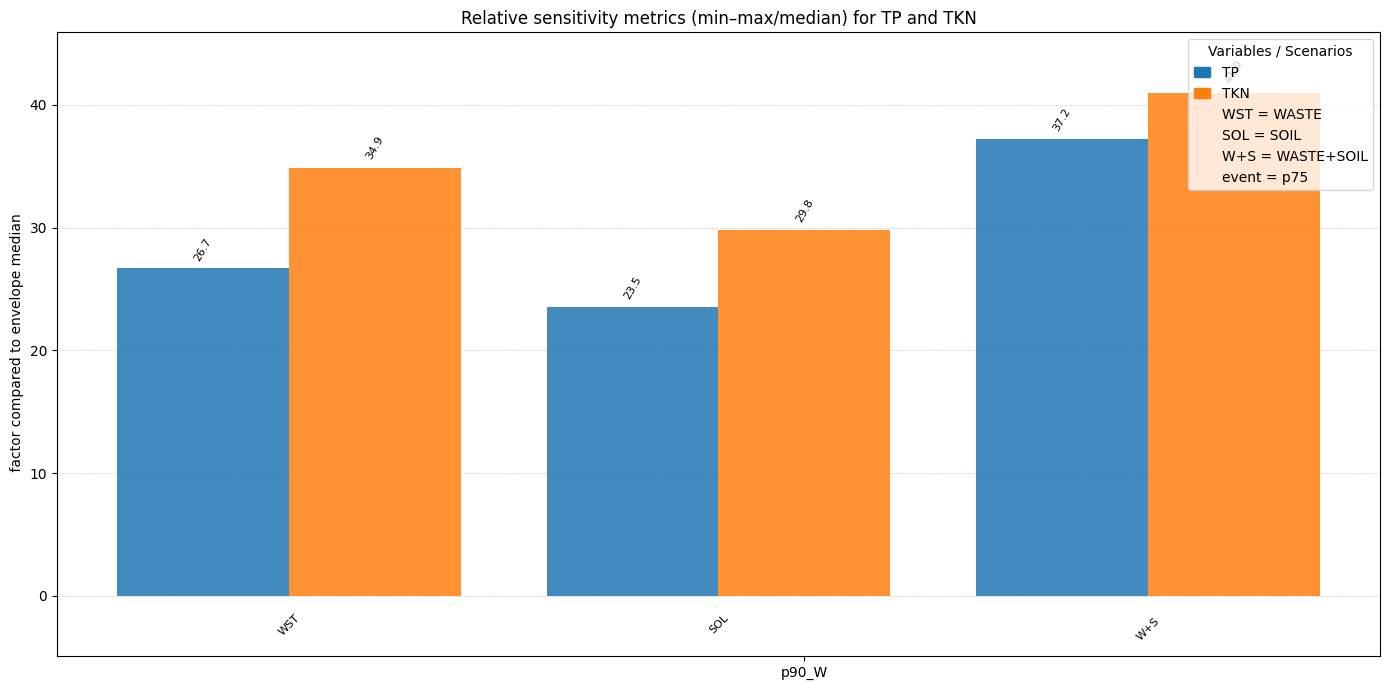

In [7]:
# Optional: display names (if you want shorter labels); otherwise omit stat_label_map


stats = ch_1  # or ch_2


stat_display_names = {k: k for k in stats["metrics"].keys()}

fig, ax = plot_nested_sensitivity_bars(
    stats,
    # stats_order=stats_order_first_ch,  # optional
    title="Relative sensitivity metrics (min–max/median) for TP and TKN",
    y_label=" factor compared to envelope median",
    figsize=(14, 7),
    abbreviations={"WASTE": "WST", "SOIL": "SOL", "WASTE+SOIL": "W+S", "p75":"event"},
    #value_format=lambda v: f"{v:.1f}",   # or omit and use annotate_decimals
    #annotate_decimals=2,
    #format_map=format_val,
    #bar_alpha=0.85,
    annotate_rotation=60,
    #scenario_label_rotation=45,
    #scenario_spacing=0.06,
    #bar_width=0.12,
    #bottom_margin_for_labels=0.12,
    #stat_label_map=stat_display_names
)


In [16]:
Input spec 

Goal: Provide a JSON-like Python dict for stats_data to drive the chart. Statistics are flexible; scenarios and variables are fixed by the function.

Required structure:

{
  "metrics": {
    "<STAT_NAME_1>": {
      "WASTE":      { "TP": <float>, "TKN": <float> },
      "SOIL":       { "TP": <float>, "TKN": <float> },
      "WASTE+SOIL": { "TP": <float>, "TKN": <float> }
    },
    "<STAT_NAME_2>": {
      "WASTE":      { "TP": <float>, "TKN": <float> },
      "SOIL":       { "TP": <float>, "TKN": <float> },
      "WASTE+SOIL": { "TP": <float>, "TKN": <float> }
    }
    // ... more statistics as needed
  }
}


Rules:

Statistics (the top-level keys inside "metrics") can be any strings (e.g., "Median W", "p90 W", "RW_med", "CS_abs", "CS_rel", "Coverage_frac", "RA_5", "RA_50", "RA_95").

Every statistic must include all three scenarios ("WASTE", "SOIL", "WASTE+SOIL") and within each scenario both variables ("TP", "TKN").

All values are numeric (float). If values are given as fractions in [0,1] and should be displayed as percentages, the caller should set value_format=lambda v: f"{v*100:.0f}%".

Optional ordering: pass stats_order=["Median W","p90 W","RW_med","CS_abs","CS_rel","Coverage_frac"] to control the display sequence.

Minimal working example to pass the function:



SyntaxError: invalid syntax (1078815736.py, line 1)

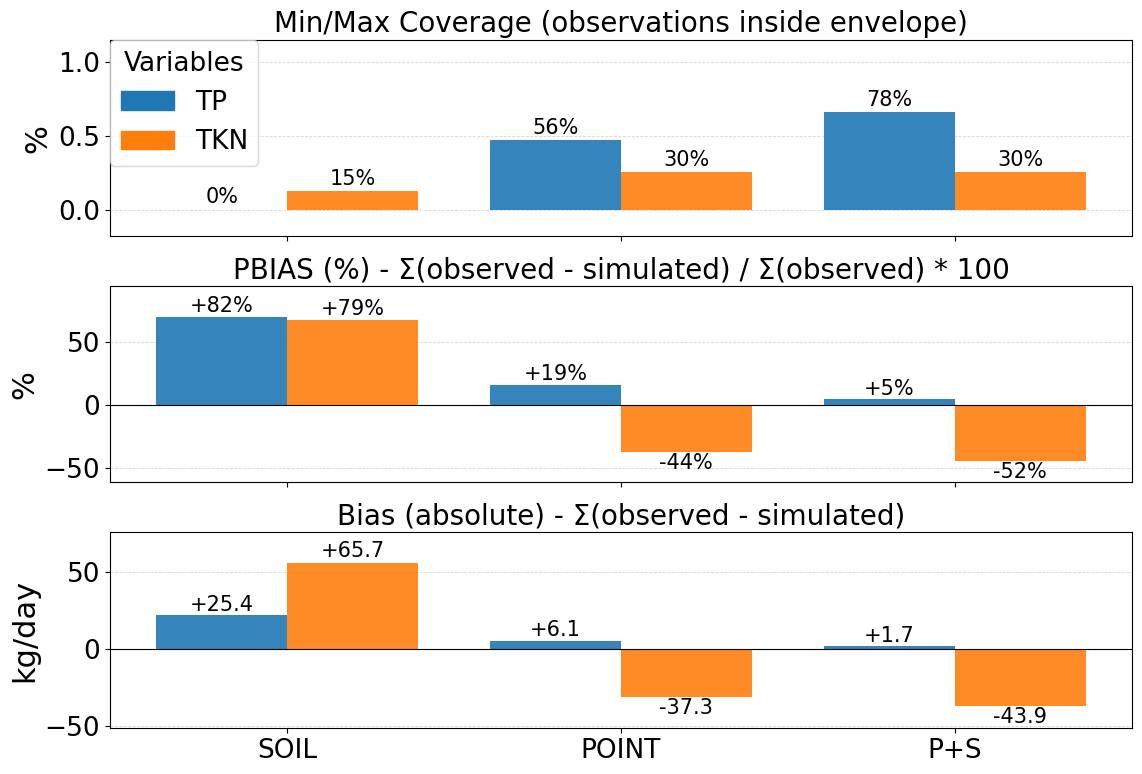

In [46]:
import math
import matplotlib.pyplot as plt

# Keep existing font + data variables already defined earlier in the notebook

height_scale = 0.85  # shrink bars to create headroom for labels

def group_left(i_scn):
    return i_scn * group_width

def bar_x(i_scn, i_var):
    return group_left(i_scn) + i_var * bar_width

def group_center(i_scn):
    return group_left(i_scn) + (subgroup_width - bar_width) / 2

def plot_metric(ax, metric_key, title, fmt, is_percent=False, signed=False, height_scale=0.85):
    # Collect original values to determine true axis limits (so bounding box unchanged)
    values = []
    for scn in scenarios:
        for var in variables:
            values.append(data[scn][var][metric_key])

    y_min = min(values)
    y_max = max(values)

    # Axis baseline
    if signed:
        ax.axhline(0, color="black", linewidth=0.8)

    # Compute y-limits (same logic as before, based on ORIGINAL values)
    ymax_abs = max(1.0, abs(y_max))
    ymin_abs = min(-1.0 if signed else 0.0, y_min)
    top_pad = 0.15 * ymax_abs
    bottom_pad = 0.18 * max(1.0, abs(ymin_abs))
    ax.set_ylim(bottom=ymin_abs - bottom_pad, top=ymax_abs + top_pad)

    # Draw scaled bars
    for i_scn, scn in enumerate(scenarios):
        for i_var, var in enumerate(variables):
            y = data[scn][var][metric_key]
            scaled_y = y * height_scale  # shrink bar
            x = bar_x(i_scn, i_var)
            ax.bar(x, scaled_y, width=bar_width, color=var_color[var], alpha=bar_alpha)

            # Place label just above (or below) scaled bar but still within axis box
            offset = 0.015 * max(1.0, abs(y))
            if y >= 0:
                ax.text(x, scaled_y + offset, fmt.format(y), ha="center", va="bottom",
                        fontsize=annot_fs,) #rotation=annotate_rotation)
            else:
                ax.text(x, scaled_y - offset, fmt.format(y), ha="center", va="top",
                        fontsize=annot_fs,) #rotation=annotate_rotation)

    # X ticks
    xticks = [group_center(i) for i in range(len(scenarios))]
    ax.set_xticks(xticks)
    ax.set_xticklabels([scenario_short.get(s, s) for s in scenarios], fontsize=tick_fs)

    ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_title(title, fontsize=title_fs)
    ax.set_ylabel("%" if is_percent else "kg/day", fontsize=label_fs)
    ax.tick_params(axis='y', labelsize=tick_fs)

# Rebuild figure with scaled bars
fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

plot_metric(
    axes[0],
    metric_key="coverage",
    title="Min/Max Coverage (observations inside envelope)",
    fmt="{:.0%}",
    is_percent=True,
    signed=False,
    height_scale=height_scale
)

plot_metric(
    axes[1],
    metric_key="pbias",
    title="PBIAS (%) - Σ(observed - simulated) / Σ(observed) * 100",
    fmt="{:+.0f}%",
    is_percent=True,
    signed=True,
    height_scale=height_scale
)

plot_metric(
    axes[2],
    metric_key="bias",
    title="Bias (absolute) - Σ(observed - simulated)",
    fmt="{:+.1f}",
    is_percent=False,
    signed=True,
    height_scale=height_scale
)

handles = [plt.Rectangle((0, 0), 1, 1, color=var_color[v]) for v in variables]

fig.legend(
    handles,
    variables,
    title="Variables",
    loc="upper left",
    bbox_to_anchor=(0.085, 0.96),
    fontsize=legend_fs,
    title_fontsize=legend_fs
)

plt.tight_layout(rect=[0.0, 0.02, 0.96, 1])
plt.show()
